## Imports Packages

In [2]:
# Imports

# python standard libraries
import os
import random

# data processing
import numpy as np
import pandas as pd

# tensorflow

import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model

# sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# imaging
import cv2
from imgaug import augmenters as img_aug
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image

## Initialize the data

In [4]:
data = pd.read_csv("Data/DatabasePS4.csv")
data = data[['Images','Steering','Speed']]
data.head()

,Images,Steering,Speed
0,image_1625667903.392419,1.153564,3.419495
1,image_1625667903.4259782,1.153564,3.419495
2,image_1625667903.6256957,0.000000,2.137756
3,image_1625667903.6596546,0.000000,2.137756
4,image_1625667903.693839,0.000000,2.137756


The below cell verifies if all taken pictures have the good format or exist. For example when the battery are over, some 0 octet files are saved
 

In [6]:
a=[]
for i in range(len(data)):
    a.append(data["Images"][i])
    a[i] = "Data/ImagesPS4/" + a[i] + ".jpg"
    
a

remove = []
for i in range(len(a)):
    if(os.path.isfile(a[i])==False):
        print(a[i])
        print(i)
        remove.append(i)
        print("\n")
        
print(len(remove))

#data=data.drop(remove)      # uncomment if remove contains elements


0


In [4]:
# This basically does the same as the above cell, but prints the files causing the problem

'''remove = []
for i in range(len(data)):
    if(os.path.getsize(a[i])<1):
        print(a[i])
        print(i)
        remove.append(i)
        print("\n")
'''              

## Visualize the data

In [7]:
# Transform string into float
data['Steering'] = data['Steering'].astype(float)
data['Speed'] = data['Speed'].astype(float)

(array([   40.,    32.,    50.,   203.,   302.,   474.,   508.,  1395.,
         1638.,  2660.,  2610.,  3063., 11146.,  7599.,  7864.,  9939.,
        16040., 13332., 17182., 13835.,  4498.,  5773.,  2837.,  1699.,
         8471.]),
 array([-35. , -32.2, -29.4, -26.6, -23.8, -21. , -18.2, -15.4, -12.6,
         -9.8,  -7. ,  -4.2,  -1.4,   1.4,   4.2,   7. ,   9.8,  12.6,
         15.4,  18.2,  21. ,  23.8,  26.6,  29.4,  32.2,  35. ]),
 <BarContainer object of 25 artists>)

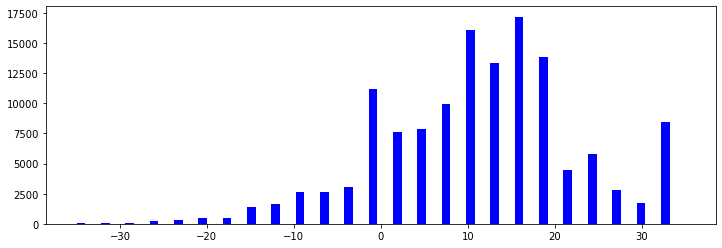

In [8]:
# Look at the distribution of steering angle
num_of_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data['Steering'], num_of_bins)

fig, axes = plt.subplots(1,1, figsize=(12,4))
axes.hist(data['Steering'], bins=num_of_bins, width=1, color='blue')

Notice that the above diagram contains angles mostly greater than -20. This makes sense, because in our training data, the car was mostly turning right. This is going to fine, because we will balance the data by randomly flip the image, and the steering angle in the image generator process.

In [ ]:
# Look at the distribution of speed
'''num_of_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data['Speed'], num_of_bins)

fig, axes = plt.subplots(1,1, figsize=(12,4))
axes.hist(data['Speed'], bins=num_of_bins, width=1, color='blue')'''

Notice that the above diagram contains speeds mostly lesser than 50. So we will keep our speeds up to 50 and we will put all the speeds above 50 to 50.

##Prepare for processing

In [9]:
# Convert the dataframe into lists. We created 3 differents lists: 
# the images paths list, the speeds list and the steering angles list
def loadData(path, data):
  imagesPath = []
  speed = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    imagesPath.append(path + "/" + indexed_data[0] + ".jpg")
    speed.append(float(indexed_data[2]))
    steering.append(float(indexed_data[1]))
  imagesPath = np.asarray(imagesPath)
  speed = np.asarray(speed)
  steering = np.asarray(steering)
  return imagesPath, speed, steering

In [11]:
imPath, sp, steer = loadData("Data/ImagesPS4",data)
speeds = np.around(sp)
steer = np.around(steer)

# We check that all lists have the same size
print(len(imPath))
print(len(speeds))
print(len(steer))

133190
133190
133190


In [12]:
# Now we shuffle the data to ameliorate the training
tmp = []

for i in range(len(steer)):
  tmp.append([steer[i], imPath[i]])

tmp = np.array(tmp)
np.random.shuffle(tmp)

steerings_preprocess = []
imagesPath = []
for i in range(len(steer)):
  steerings_preprocess.append((tmp[i][0]))
  imagesPath.append(tmp[i][1])

steerings_preprocess = [float(k) for k in steerings_preprocess]
steerings_preprocess = [int(k) for k in steerings_preprocess]
steerings_preprocess = np.array(steerings_preprocess)

imagesPath = np.array(imagesPath)


# If you don't want to shuffle the dataset, comment the above lines and uncomment below lines

#steerings = steer 
#imagesPath = imPath

We normalize our steerings values between -1 and 1.

In [13]:
steerings = steerings_preprocess/35
steerings = steerings.astype('float32')
print(min(steerings))
print(max(steerings))

-1.0
1.0


Let's see the distribution of the speeds

In [ ]:
# Look at the distribution of speed
'''num_of_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(speeds, num_of_bins)

fig, axes = plt.subplots(1,1, figsize=(12,4))
axes.hist(speeds, bins=num_of_bins, width=1, color='blue')'''

We normalize our speeds values between -1 and 1.

In [ ]:
'''speeds = (speeds/25) - 1    # since speeds are in [0,50]
speeds = speeds.astype('float32')
print(min(speeds))
print(max(speeds))'''

We create a vector containing the speeds and the steering angles. It is used to predict both speed and steering angle (but not used for this project since we only focus on steering angle).

In [ ]:
'''speedsSteerings = np.array([speeds, steerings])
speedsSteerings = np.transpose(speedsSteerings)
print(speedsSteerings)'''

We show an example of image saved by the camera

In [ ]:
'''imageTest = plt.imread(imagesPath[0])
plt.imshow(imageTest)
plt.show()'''

## Split for training and validation

We will split the training data into training/validation sets with a 80/20 split with sklearn’s train_test_split method.

In [15]:
xTrain, xVal, yTrain, yVal = train_test_split(imagesPath, steerings, test_size=0.2, random_state=10)

print('Total Training Images : ',len(xTrain))
print('Total Validation Images : ',len(xVal))
print('Total Images : ',len(imagesPath))

Total Training Images :  106552
Total Validation Images :  26638
Total Images :  133190


## Augment data

Since we only have a few hundred images, to train a deep network, we need a lot more images. Instead of running our car, let's try to augment our data. There are a couple of ways to do that:
- Zoom: crop out a smaller image from the center
- Pan: crop out a smaller image from left or right side
- Adjust brightness of the image
- Flip the image horizontally, i.e do a left to right flip, and change the steering angle correspondingly
- Introduce a Gaussian blur

We can combine the above augmentation techniques to generate 100s times of the training images, with just a few hundred real images.

By randomly applying any or all of these 5 operations on the original images, we can generate a lot more training data from our original images, which makes our final trained model much more robust.

In [17]:
# This function serves to read the images in the correct way
def my_imread(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

Text(0.5, 1.0, 'zoomed')

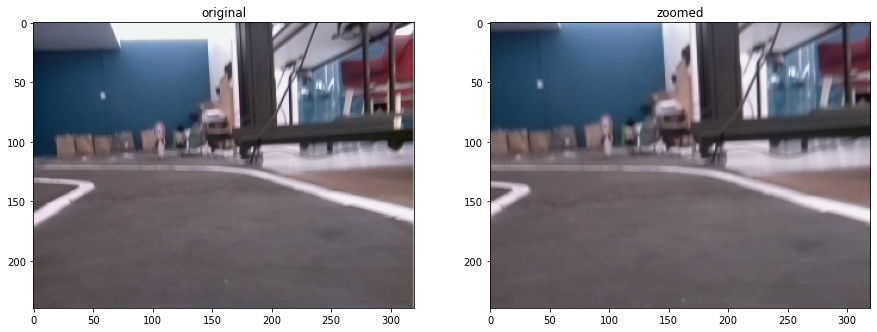

In [16]:
def zoom(image):
    zoom = img_aug.Affine(scale=(1, 1.3))  # zoom from 100% (no zoom) to 130%
    image = zoom.augment_image(image)
    return image

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(imagesPath[0])
image_zoom = zoom(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("original")
axes[1].imshow(image_zoom)
axes[1].set_title("zoomed")

Text(0.5, 1.0, 'panned')

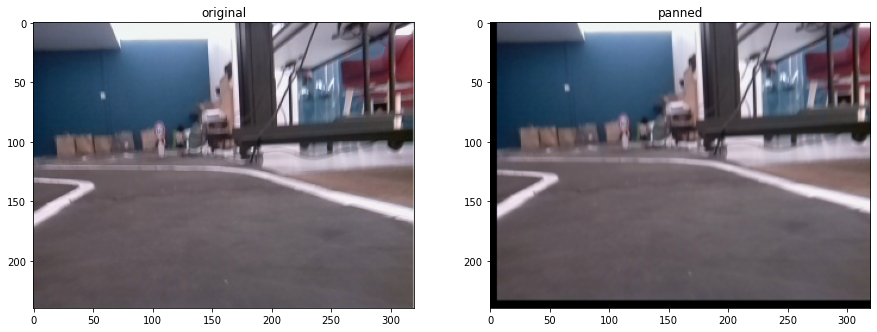

In [18]:
def pan(image):
    # pan left / right / up / down about 10%
    pan = img_aug.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
    image = pan.augment_image(image)
    return image

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(imagesPath[0])
image_pan = pan(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("original")
axes[1].imshow(image_pan)
axes[1].set_title("panned")

Text(0.5, 1.0, 'brightness adjusted')

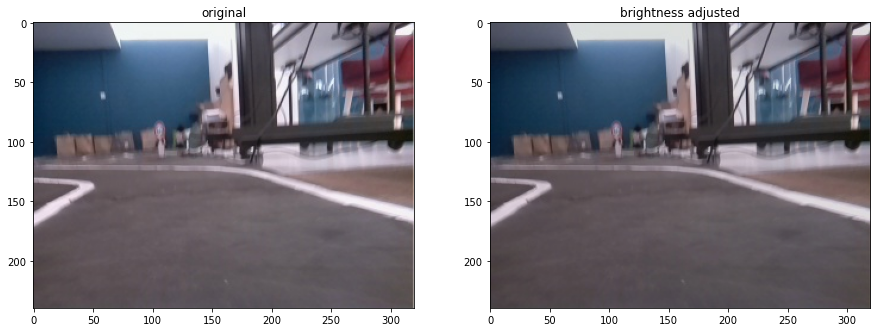

In [19]:
def adjust_brightness(image):
    # increase or decrease brightness by 30%
    brightness = img_aug.Multiply((0.7, 1.3))
    image = brightness.augment_image(image)
    return image

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(imagesPath[0])
image_brightness = adjust_brightness(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("original")
axes[1].imshow(image_brightness)
axes[1].set_title("brightness adjusted")

Text(0.5, 1.0, 'blurred')

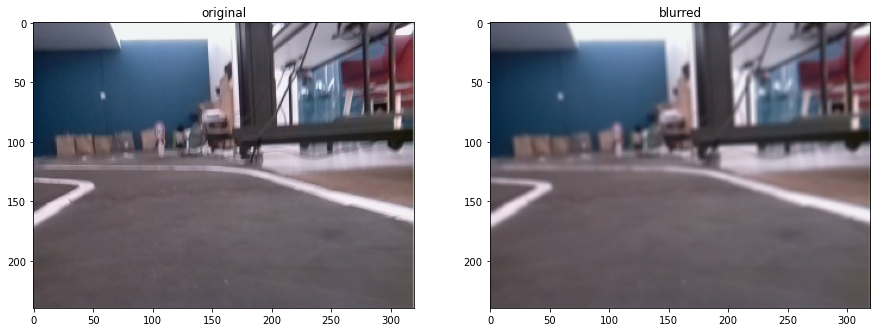

In [20]:
def blur(image):
    kernel_size = random.randint(1, 5)  # kernel larger than 5 would make the image way too blurry
    image = cv2.blur(image,(kernel_size, kernel_size))
   
    return image

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(imagesPath[0])
image_blur = blur(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("original")
axes[1].imshow(image_blur)
axes[1].set_title("blurred")

Text(0.5, 1.0, 'flipped, angle=-0.4857143')

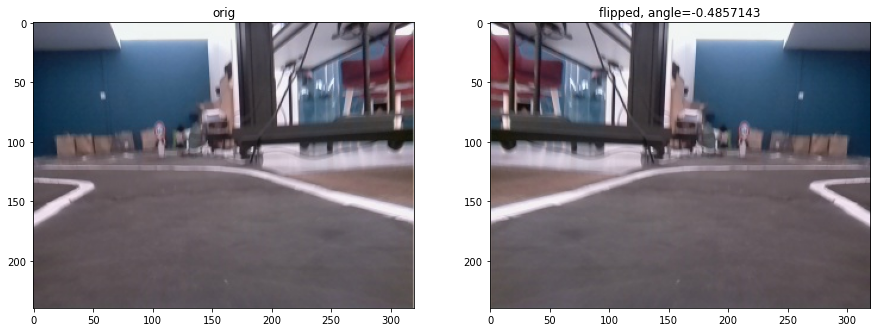

In [21]:
def random_flip(image, steering_angle):
    is_flip = random.randint(0, 1)
    #is_flip = 1      # uncomment if you want every image flipped for the training
    
    if is_flip == 1:
        # randomly flip horizontally
        image = cv2.flip(image,1)
        steering_angle = - steering_angle
   
    return image, steering_angle

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(imagesPath[0])
image_flip, steering_angle = random_flip(image_orig, steerings[0])
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_flip)
axes[1].set_title("flipped, angle=%s" % steering_angle)

In [22]:
# put it together
def random_augment(image, steering_angle):
    if np.random.rand() < 0.5:
        image = pan(image)
    if np.random.rand() < 0.5:
        image = zoom(image)
    if np.random.rand() < 0.5:
        image = blur(image)
    if np.random.rand() < 0.5:
        image = adjust_brightness(image)
    image, steering_angle = random_flip(image, steering_angle)
    
    return image, steering_angle

# show a few randomly augmented images
'''ncol = 2
nrow = 10
fig, axes = plt.subplots(nrow, ncol, figsize=(15, 50))

for i in range(nrow):
    rand_index = random.randint(0, len(imagesPath) - 1)
    image_path = imagesPath[rand_index]
    steering_angle_orig = steerings[rand_index]
    
    image_orig = my_imread(image_path)
    image_aug, steering_angle_aug = random_augment(image_orig, steering_angle_orig)
    
    axes[i][0].imshow(image_orig)
    axes[i][0].set_title("original, angle=%s" % steering_angle_orig)
    axes[i][1].imshow(image_aug)
    axes[i][1].set_title("augmented, angle=%s" % steering_angle_aug)'''

'ncol = 2\nnrow = 10\nfig, axes = plt.subplots(nrow, ncol, figsize=(15, 50))\n\nfor i in range(nrow):\n    rand_index = random.randint(0, len(imagesPath) - 1)\n    image_path = imagesPath[rand_index]\n    steering_angle_orig = steerings[rand_index]\n    \n    image_orig = my_imread(image_path)\n    image_aug, steering_angle_aug = random_augment(image_orig, steering_angle_orig)\n    \n    axes[i][0].imshow(image_orig)\n    axes[i][0].set_title("original, angle=%s" % steering_angle_orig)\n    axes[i][1].imshow(image_aug)\n    axes[i][1].set_title("augmented, angle=%s" % steering_angle_aug)'

## Preprocess

The top half of the image is not relevant to predicting the steering angle, so we will just crop it out. Secondly, we divide our pixels value by 255 to normalize them.


In [23]:
def img_preprocess(image):
    height, _, _ = image.shape
    image = image[int(height/2):,:,:]  # remove top half of the image, as it is not relavant for lane following
    image = image / 255                # normalizing the pixel values 
    return image


'''fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(imagesPath[0])
image_processed = img_preprocess(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("original")
axes[1].imshow(image_processed)
axes[1].set_title("processed")
print(image_processed.shape)'''


'fig, axes = plt.subplots(1, 2, figsize=(15, 10))\nimage_orig = my_imread(imagesPath[0])\nimage_processed = img_preprocess(image_orig)\naxes[0].imshow(image_orig)\naxes[0].set_title("original")\naxes[1].imshow(image_processed)\naxes[1].set_title("processed")\nprint(image_processed.shape)'

## Create model

**Transfer learning**

Instead training all the model we will use transfer learning.

Transfer learning is a machine learning method where a model developed for a task is reused as the starting point for a model on a second task. 
Transfer learning is an optimization that allows rapid progress or improved performance when modeling the second task.
Hence, it will help us a lot to overcome the lack of images.

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Input

We will take here some pretrained models 

In [ ]:
# Models used below
from tensorflow.keras.applications.vgg16 import VGG16
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(120,320,3)) # include_top=False is to not keep the top layer

from tensorflow.keras.applications.inception_v3 import InceptionV3
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(120,320,3))

from tensorflow.keras.applications.resnet50 import ResNet50
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(120, 320, 3))

from tensorflow.keras.applications.xception import Xception
xception_model = Xception(weights='imagenet', include_top=False, input_shape=(120, 320, 3))

from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
mobilenet_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(120,320,3))

from tensorflow.keras.applications.densenet import DenseNet121
densenet_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(120,320,3))

from tensorflow.keras.applications.nasnet import NASNetMobile
nasnet_model = NASNetMobile(weights='imagenet', include_top=False, input_shape=(224,224,3))

**Freeze the layer**

It is important to freeze the convolutional base before we compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. VGG16 has many layers, so setting the entire model's trainable flag to False will freeze all of them.

In [25]:
for layer in vgg_model.layers:
  layer.trainable = False

for layer in inception_model.layers:
  layer.trainable = False

for layer in resnet_model.layers:
  layer.trainable = False

for layer in xception_model.layers:
  layer.trainable = False

for layer in mobilenet_model.layers:
  layer.trainable = False

for layer in densenet_model.layers:
  layer.trainable = False

for layer in nasnet_model.layers:
  layer.trainable = False

###**VGG model**

In [ ]:
# Architecture of the VGG16 model
vgg_model.summary()

In [ ]:
# Plot the graph of the VGG16 model
plot_model(vgg_model, to_file='VGG_graph.png')

Dense: Fully connected layer and the most common type of layer used on multi-layer perceptron models. Dense implements the operation: output = activation(dot(input, kernel) + bias) where activation is the element-wise activation function passed as the activation argument, kernel is a weights matrix created by the layer, and bias is a bias vector created by the layer.

We will use for every model the tanh activation for the final layer since our values are between -1 and 1

In [ ]:
# We add to the VGG model our finals layers from the Nvidia model
# elu : Expenential Linear Unit, similar to leaky Relu

x_vgg = Flatten()(vgg_model.output)
d_vgg = Dense(50, activation='elu')(x_vgg)
dense3_vgg = Dense(10, activation='elu')(d_vgg)
output_vgg = Dense(1, activation='tanh')(dense3_vgg)

In [ ]:
vgg = Model(inputs=vgg_model.input, outputs=output_vgg)

In [ ]:
optimizer_vgg = Adam(learning_rate=1e-3) # lr is learning rate
vgg.compile(loss='mse', optimizer=optimizer_vgg)

In [ ]:
# Architecture of this new model
vgg.summary()

In [ ]:
# Plot the graph of this new model
plot_model(vgg, to_file='Model_graph.png')

In [ ]:
# Check the trainable status of the individual layers
for layer in vgg.layers:
  print(layer, layer.trainable)

**Model compilation**

Once we have defined our model, it needs to be compiled.
This creates the efficient structures used by the underlying backend in order to efficiently execute our model during training.
We compile our model using the compile() function and it accepts two important attributes:
- Model optimizer.
- Loss function.

The optimizer is the search technique used to update weights in our model.
Some popular gradient descent optimizers: 
- SGD (stochastic gradient descent with support of momentum)
- RMSprop (adaptive learning rate optimization method proposed by Geoffrey Hinton)
- Adam (Adaptive Moment Estimation that also uses adaptive learning rates)

The loss function, also called the objective function is the evaluation of the model used by the optimizer to navigate the weight space. This function is used to compute the error as the difference between the actual output and the predicted output.
Some common examples include:
- mse: for mean squared error
- binary_crossentropy: for binary logarithmic loss (logloss)
- categorical_crossentropy: for multi-class logarithmic loss (logloss)

Since this is a regression problem not classification problem, we use MSE (Mean Squared Error) as loss function

**Inception Model**

In [ ]:
# Architecture of the InceptionV3 model
inception_model.summary()

In [ ]:
# Plot the graph of the InceptionV3 model
plot_model(inception_model, to_file='Inception_graph.png')

In [ ]:
x_inception= Flatten()(inception_model.output)
d_inception = Dense(50, activation='elu')(x_inception)
e_inception = Dense(15, activation='elu')(d_inception)
dense3_inception = Dense(10, activation='elu')(e_inception)
output_inception = Dense(1, activation='tanh')(dense3_inception)

In [ ]:
inception = Model(inputs=inception_model.input, outputs=output_inception)

In [ ]:
optimizer_inception = Adam(learning_rate=1e-3) 
inception.compile(loss='mse', optimizer=optimizer_inception)

In [ ]:
# Architecture of our final model
inception.summary()

In [ ]:
# Plot the graph of our final model
plot_model(inception, to_file='Model_graph.png')

In [ ]:
# Check the trainable status of the individual layers
for layer in inception.layers:
  print(layer, layer.trainable)

**ResNet Model**

In [ ]:
x_resnet = Flatten()(resnet_model.output)
d_resnet = Dense(50, activation='elu')(x_resnet)
dense3_resnet = Dense(10, activation='elu')(d_resnet)
output_resnet = Dense(1, activation='tanh')(dense3_resnet)

In [ ]:
resnet = Model(inputs=resnet_model.input, outputs=output_resnet)
optimizer_resnet = Adam(learning_rate=1e-3) 
resnet.compile(loss='mse', optimizer=optimizer_resnet)

**Xception Model**

In [ ]:
x_xception = Flatten()(xception_model.output)
dense1_xception = Dense(50, activation='elu')(x_xception)
d_xception = Dense(15, activation='elu')(dense1_xception)
dense3_xception = Dense(10, activation='elu')(d_xception)
output_xception = Dense(1, activation='tanh')(dense3_xception)

In [ ]:
xception = Model(inputs=xception_model.input, outputs=output_xception)
optimizer_xception = Adam(learning_rate=1e-3) 
xception.compile(loss='mse', optimizer=optimizer_xception)

**MobileNet model**

In [ ]:
x_mobilenet = Flatten()(mobilenet_model.output)
dense1_mobilenet = Dense(100, activation='elu')(x_mobilenet)
d_mobilenet = Dense(50, activation='elu')(dense1_mobilenet)
dense3_mobilenet = Dense(10, activation='elu')(d_mobilenet)
output_mobilenet = Dense(1, activation='tanh')(dense3_mobilenet)

In [ ]:
mobilenet = Model(inputs=mobilenet_model.input, outputs=output_mobilenet)
optimizer_mobilenet = Adam(learning_rate=1e3) 
mobilenet.compile(loss='mse', optimizer=optimizer_mobilenet)

**DenseNet model**

In [ ]:
x_densenet = Flatten()(densenet_model.output)
d_densenet = Dense(50, activation='elu')(x_densenet)
dense3_densenet = Dense(10, activation='elu')(d_densenet)
output_densenet = Dense(1, activation='tanh')(dense3_densenet)

In [ ]:
densenet = Model(inputs=densenet_model.input, outputs=output_densenet)
optimizer_densenet = Adam(learning_rate=1e3) 
densenet.compile(loss='mse', optimizer=optimizer_densenet)

**NasNet model**

In [ ]:
x_nasnet = Flatten()(nasnet_model.output)
dense1_nasnet = Dense(50, activation='elu')(x_nasnet)
d_nasnet = Dense(15, activation='elu')(dense1_nasnet)
dense3_nasnet = Dense(10, activation='elu')(d_nasnet)
output_nasnet = Dense(1, activation='tanh')(dense3_nasnet)

In [ ]:
nasnet = Model(inputs=nasnet_model.input, outputs=output_nasnet)
optimizer_nasnet = Adam(learning_rate=1e-2) 
nasnet.compile(loss='mse', optimizer=optimizer_nasnet)

**Nvidia model**

In [ ]:
## Models taken from NVidia 
for layer in resnet_model.layers[:-4]:
    layer.trainable = False

def nvidia_model():
  model = Sequential()
  model.add(resnet_model)
  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(100, activation='elu'))
  model.add(Dropout(0.5))
  model.add(Dense(50, activation='elu'))
  model.add(Dropout(0.5))
  model.add(Dense(10, activation='elu'))
  model.add(Dropout(0.5))
  model.add(Dense(1))
  optimizer = Adam(learning_rate=1e-3)
  model.compile(loss='mse', optimizer=optimizer)
  return model

nvidia = nvidia_model()



def nvidia_modified():
  model = Sequential()
  #1st layer
  model.add(Conv2D(24, kernel_size=(5,5), strides=(2,2), input_shape=(120,320,3),activation='elu'))
  #2nd layer
  model.add(Conv2D(36, kernel_size=(5,5), strides=(2,2), activation='elu'))
  #3rd layer
  model.add(Conv2D(48, kernel_size=(5,5), strides=(2,2), activation='elu'))
  #4th layer
  model.add(Conv2D(64, kernel_size=(3,3), activation='elu'))
  #5th layer
  model.add(Conv2D(64, kernel_size=(3,3), activation='elu'))
  #1st Dense Layer
  model.add(Flatten())
  model.add(Dense(100, activation='elu'))
  #model.add(Dropout(0.5))
  #2nd Dense Layer
  model.add(Dense(50, activation='elu'))
  #model.add(Dropout(0.5))
  #3rd Dense Layer
  model.add(Dense(10, activation='elu'))
  #model.add(Dropout(0.5))
  #output
  model.add(Dense(1))
  #Compile model
  model.compile(Adam(learning_rate=0.001), loss = 'mse')
  filepath = "NvidiaModified2/model.json"
  # Serves to save the best model, based on the loss value
  checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, verbose=1, save_best_only=True)
  callbacks_list = [checkpoint]
  return model

nvidiamodified = nvidia_modified()

In [26]:
from tensorflow.keras import layers

def lane_following_model():
    model = Sequential([
      layers.Conv2D(32, (3, 3), activation='relu', input_shape=(120, 320, 3), padding='same'),
      layers.MaxPooling2D((2, 2)),
      layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
      layers.MaxPooling2D((2, 2)),
      layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
      layers.MaxPooling2D((2, 2)),
      layers.Dropout(0.2),
      layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
      layers.MaxPooling2D((2, 2)),
      layers.Dropout(0.2),
      layers.GlobalAvgPool2D(),
      layers.Dense(64, activation='relu'),
      # Output layer
      layers.Dense(1)
    ])
    
    model.compile(optimizer='adam',loss='mse')
    
    return model

lane_following = lane_following_model()



## Training

Now that both the data and model are ready, we will start to train the data.

For those who have used Keras to train deep-learning models, we usually use the model.fit() command. But notice that today we used model.fit_generator() command. This is because we are not using a static set of training data, our training data is generated dynamically from our original 138 253 images via image augmentation discussed earlier. For this to work, we need to create a helper function that does the augmentation and then return a new batch of training data to model.fit_generator()on each iteration.

In [27]:
def image_data_generator(image_paths, steering_angles, batch_size, is_training):
    while True:
        batch_images = []
        batch_steering_angles = []
        
        for i in range(batch_size):
            random_index = random.randint(0, len(image_paths) - 1)
            image_path = image_paths[random_index]
            image = my_imread(image_paths[random_index])
            steering_angle = steering_angles[random_index]
            if is_training:
                # training: augment image
                image, steering_angle = random_augment(image, steering_angle)
              
            image = img_preprocess(image)
            batch_images.append(image)
            batch_steering_angles.append(steering_angle)
            
        yield(np.asarray(batch_images), np.asarray(batch_steering_angles))

Some examples of our train and val set.

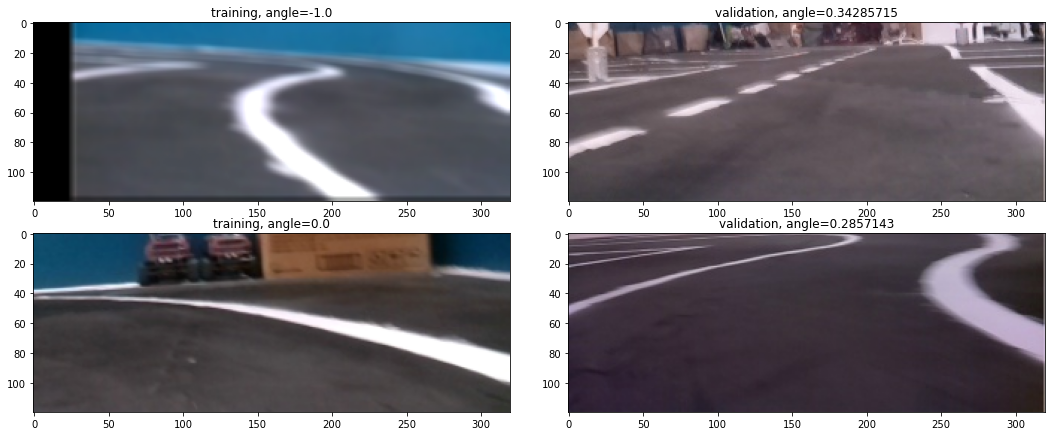

In [28]:
ncol = 2
nrow = 2

X_train_batch, y_train_batch = next(image_data_generator(xTrain, yTrain, nrow, True))
X_valid_batch, y_valid_batch = next(image_data_generator(xVal, yVal, nrow, False))

fig, axes = plt.subplots(nrow, ncol, figsize=(15, 6))
fig.tight_layout()

for i in range(nrow):
    axes[i][0].imshow(X_train_batch[i])
    axes[i][0].set_title("training, angle=%s" % y_train_batch[i])
    axes[i][1].imshow(X_valid_batch[i])
    axes[i][1].set_title("validation, angle=%s" % y_valid_batch[i])

**Model training**

The model is trained on NumPy arrays using the fit() function.

Epochs is the number of times that the model is exposed to the training dataset.

Batch_size is the number of samples that will be propagated through the network.

The fit function also allows for some basic evaluation of the model during training. We can provide a validation_data tuple of (x, y) of data to evaluate.

Fitting the model returns a history object with details and metrics calculated for the model each epoch. This can be used for graphing model performance.

In [ ]:
batch_size=32

history = lane_following.fit(image_data_generator( xTrain, yTrain, batch_size=batch_size, is_training=True),
                              steps_per_epoch=600,
                              epochs=30,
                              validation_data = image_data_generator( xVal, yVal, batch_size=batch_size, is_training=False),
                              validation_steps=300,
                              verbose = 1
                              )

Epoch 1/30
600/600 [==============================] - 118s 197ms/step - loss: 0.0534 - val_loss: 0.0435
Epoch 2/30
600/600 [==============================] - 124s 207ms/step - loss: 0.0532 - val_loss: 0.0443
Epoch 3/30
600/600 [==============================] - 124s 206ms/step - loss: 0.0524 - val_loss: 0.0436
Epoch 4/30
600/600 [==============================] - 125s 209ms/step - loss: 0.0502 - val_loss: 0.0397
Epoch 5/30
600/600 [==============================] - 130s 218ms/step - loss: 0.0496 - val_loss: 0.0426
Epoch 6/30
600/600 [==============================] - 123s 205ms/step - loss: 0.0497 - val_loss: 0.0424
Epoch 7/30
600/600 [==============================] - 127s 212ms/step - loss: 0.0496 - val_loss: 0.0398
Epoch 8/30
600/600 [==============================] - 122s 204ms/step - loss: 0.0493 - val_loss: 0.0400
Epoch 9/30
600/600 [==============================] - 121s 202ms/step - loss: 0.0465 - val_loss: 0.0412
Epoch 10/30
600/600 [==============================] - 123s 205m

In [30]:
# Save the model
model_json = lane_following.to_json()
with open("LaneFollowingModel/model.json", "w") as json_file:
    json_file.write(model_json)
lane_following.save_weights("LaneFollowingModel/model_weights.h5")
print("Saved model to disk")

Saved model to disk


Now it is time to see how well the training went. First thing is to plot the loss function of both training and validation sets.

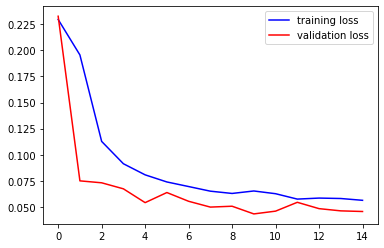

In [31]:
plt.plot(history.history['loss'],color='blue')
plt.plot(history.history['val_loss'],color='red')
plt.legend(["training loss", "validation loss"])

In [ ]:
from tensorflow.keras.models import model_from_json

# load json and create model

json_file = open("LaneFollowingModel/model.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("LaneFollowingModel/model_weights.h5")
print("Loaded model from disk")

In [33]:
# Convert the model into Tensorflow lite
converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
tflite_model = converter.convert()

# Save the model

with open('LaneFollowingModel/model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp538gteor/assets


## Testing

We will test our neural network with some images from the training.

In [ ]:
i = 60000   # choose an image from all availables

print("The real angle is :", steerings[i]*35)
imageTest1 = plt.imread(imagesPath[i])
img1 = imageTest1
img1 = img_preprocess(img1) # Preprocess the image

img1 = np.reshape(img1,(-1,120,320,3)) # Reshape the image to put it in the neural nework
prediction1 = loaded_model.predict(img1)

print("The predicted angle is:", prediction1[0][0]*35)

plt.imshow(imageTest1)
#my_imread(img1)
plt.show()
print(prediction1)

We will now test the TFLite model as it is the model used in the car

In [ ]:
i = 42000

# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="JulieModel/model.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on random input data.
input_shape = input_details[0]['shape']
image_tested = plt.imread(imagesPath[i])
im = image_tested
im = img_preprocess(image_tested) # Preprocess the image

im = np.reshape(im,(-1,120,320,3)).astype('float32')
interpreter.set_tensor(input_details[0]['index'], im)

interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])
print("The real angle is:", steerings[i]*35)
print("The predicted angle is:", output_data[0][0]*35)

We will see the mean difference and computation time with the TFLite model

In [ ]:
import time
tps1 = time.time()
diff = 0
nb = 20000       # number of images taken for the test
for i in range(nb):
  image_tested = plt.imread(imagesPath[i+1])
  im = image_tested
  im = img_preprocess(image_tested) # Preprocess the image

  im = np.reshape(im,(-1,120,320,3)).astype('float32')
  interpreter.set_tensor(input_details[0]['index'], im)

  interpreter.invoke()
  output_data = interpreter.get_tensor(output_details[0]['index'])
  diff = diff + np.abs(output_data[0][0]-steerings[i])
  
tps2 = time.time()
print("Number of samples : ", nb)
print("Execution time : ",tps2-tps1)
print("Mean Execution Time : ", (tp2-tp1)/nb)
print("Mean Difference : ", diff*35/nb)